# Setup - defining parameters that probably don't need to be changed

In [15]:

#user defined parameters

#thresholds for spot detection (*std)
sigma1=60   #threshold for finding spots
sigma2=15   #threshold for calculating moments

#other spot detection parameters - probably won't need to change
boxFind=10   #box size for finding spots
boxCent=6   #box size for centroiding
nmin=10     #minimum acceptable # of pixels in spot
nmax=90     #maximum acceptable # of pixels in spot
maxIt=20    #maximum # interations for centroiding

#set to non zero to override automatic fwhm determination
fwhmx=0
fwhmy=0

#inter = 1 for notebook, 0 for scripts (displaying plots)
inter=1

#cenFlag='local' to run from local disk, 'db' to read from database
cenFlag='local'
#cenFlag='db'

#dataSource = 'pinhole'
dataType='pinhole'

#configuration for rotator center

config="oct18"
#config="aug19"
#config="calib"


#database info - update as needed
user='pfs'
passwd='fps'
host='133.40.164.208'
dbname='pfspass'
conn=None


# Setup - importing

In [16]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
from importlib import reload  #for debugging purposes
from scipy.stats import sigmaclip

#the try/except is for using in the MHS environment, or standalone. 

try:
    import mcsActor.Visualization.vis_plot as visplot
except:
    import vis_plot as visplot

try:
    import mcsActor.Visualization.vis_calc as viscalc
except:
    import vis_calc as viscalc

try:
    import mcsActor.Visualization.vis_spots as visspot
except:
    import vis_spots as visspot

try:
    import mcsActor.Visualization.vis_util as visutil
except:
    import vis_util as visutil



# connect to database

In [17]:

reload(visutil)
#connect to database if in DB mode
if(cenFlag=='db'):
    conn=visutil.dbConnect(user=user,dbname=dbname,passwd=pfspass,host=host)
    

# parameters that change for each run

In [18]:

#set frame ID minimum and maximum values (inclusive)

frameId1=4324
#frameId2=4425
frameId2=4344

#any frames to skip (bad data, etc)
frameSkip=[]   

#source directory data files in local mode
sourceDir="/Volumes/Vaal/Commissioning Run/2018-10-25/"

#subtitle for plots - first frame ID plus tag
stitle=" ["+str(frameId1).zfill(4)+"] (newcode)"

fPref="PFSC"
#get various file name inforamtion
files,prefix,centroidFile,frameIDs=visutil.getFileNames(frameId1,frameId2,frameSkip,sourceDir,fPref,dataType)

nfiles=len(files)
print("Read "+str(len(files))+" files names. First = "+str(frameId1)+" Last="+str(frameId2))
print("prefix="+prefix+" centroidFile="+centroidFile)


Read 21 files names. First = 4324 Last=4344
prefix=see_04324_04344 centroidFile=see_04324_04344_centroids.dat


# calculate threshold values and region (once per config)

In [6]:
#not needed if pulling from DB
reload(visspot)
reload(visutil)

image=visutil.getImage(files[0])
xrange,yrange=visspot.getRegion(image,4,2)
thresh1,thresh2,xrange,yrange=visspot.getThresh(image,xrange,yrange,sigma1,sigma2)

print("Thresholds=",thresh1,thresh2)
print("Boundaries of region (x1,x2,y1,y2): ",xrange[0],xrange[1],yrange[0],yrange[1])


Thresholds= 1837.7015700908241 1094.3852265489627
Boundaries of region (x1,x2,y1,y2):  200 4106 2739 6670


# Do the centroiding for a set of database, either locally or retrieve from DB


Centroiding with Parameters:  1837.7015700908241 1094.3852265489627 0 0 7 6 10 90 20
21 Frames. Centroiding 1: 3543, 2: 3443, 3: 3444, 4: 3449, 5: 3450, 6: 3456, 7: 3456, 8: 3483, 9: 3483, 10: 3528, 11: 3528, 12: 3542, 13: 3542, 14: 3542, 15: 3542, 16: 3542, 17: 3543, 18: 3543, 19: 3543, 20: 3542, 21: 3542, 


<IPython.core.display.Javascript object>


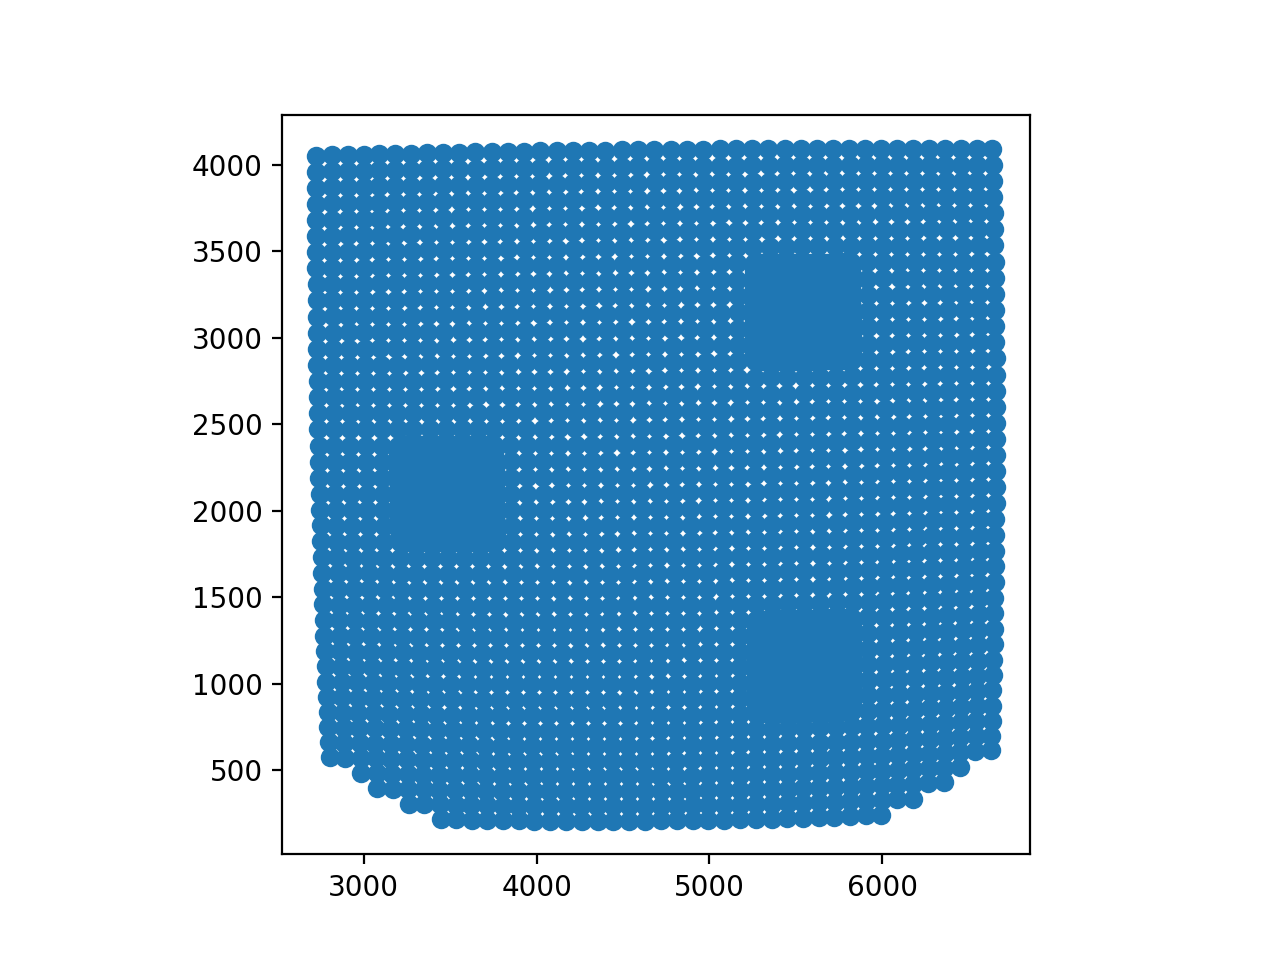

In [12]:
reload(viscalc)
reload(visspot)


#set redo=1 to recalculate values, redo=0 to read from files    
redo=1

#local case - either read files and calculate, or load data from a file. 
if(cenFlag=="local"):

    if(redo==1):
        print("Centroiding with Parameters: ",thresh1,thresh2,fwhmx,fwhmy,boxFind,boxCent,nmin,nmax,maxIt)
        xlast,ylast=visspot.getAllCentroids(files,centroidFile,thresh1,thresh2,fwhmx,fwhmy,boxFind,boxCent,nmin,nmax,maxIt)
        centroids=np.loadtxt(centroidFile)
    else:
        printf("Loading Centroids from Local File.")
        centroids=np.loadtxt(centroidFile)
#db case - read from database
elif(cenFlag=='db'):
    printf("Loading Centroids from DB.")
    centroids=visspot.getCentroidsDB(conn,frameIDs)        
        

#extract the first set of centroids for summary plot
ind=np.where(centroids[:,0]==0)
xlast=centroids[ind,1].ravel()
ylast=centroids[ind,2].ravel()
         
visplot.checkCentroids(xlast,ylast,1,prefix,inter)


In [13]:

reload(viscalc)
xCorner=[]
yCorner=[]

for i in range(nfiles):
    ind=np.where(centroids[:,0]==i)
    x=centroids[ind,1].ravel()
    y=centroids[ind,2].ravel()

    x0,x1,y0,y1=viscalc.getCorners(x,y)
    xCorner.append(x0)
    yCorner.append(y0)

xCorner=np.array(xCorner)
yCorner=np.array(yCorner)



<IPython.core.display.Javascript object>


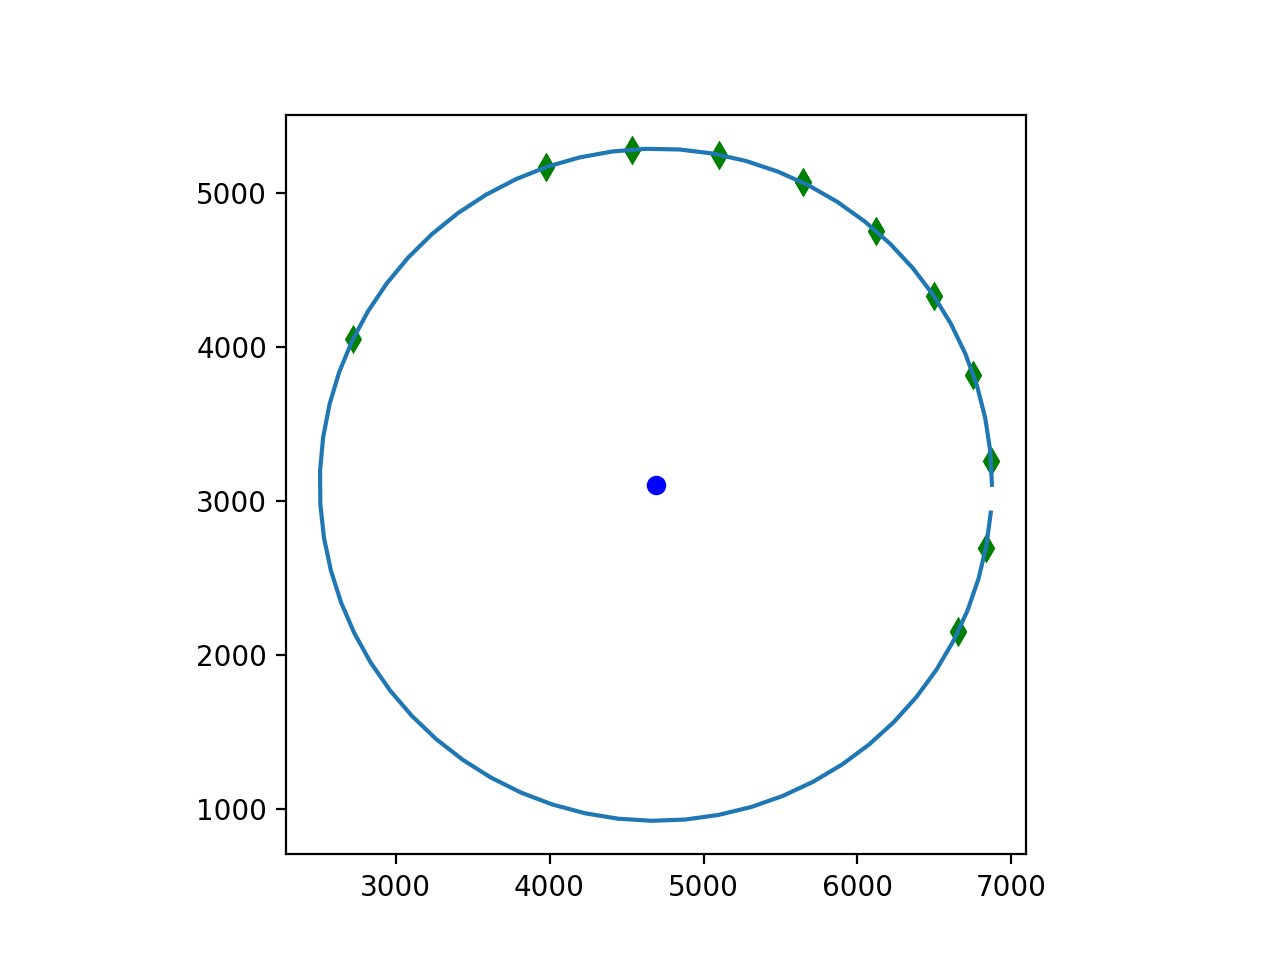

4690.432157918923 3104.5629579664223 2182.915066070212


In [14]:
reload(viscalc)
fig,ax=plt.subplots()
ax.plot(xCorner,yCorner,'dg')

coords=[xCorner,yCorner]
xc,yc,r,_=viscalc.least_squares_circle(xCorner,yCorner)
print(xc,yc,r)

xval=[]
yval=[]
for theta in np.arange(0,2*np.pi,0.1):
    xval.append(r*np.cos(theta)+xc)
    yval.append(r*np.sin(theta)+yc)
    
ax.plot(xval,yval)
ax.plot([xc],[yc],'ob')
ax.set_aspect('equal')
plt.show()
    
